# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Recurrent Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.


In [26]:
import os
import sys
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN, Dense
print(tf.__version__)

2.18.0


In [27]:
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available and detected.")
    print(gpu_available)
else:
    print("No GPU detected. TensorFlow will use the CPU.")
    sys.exit("Exiting: No GPU found.")

GPU is available and detected.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
path = kagglehub.dataset_download("rccrea/daily-minimum-temperature-in-melbourne")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/daily-minimum-temperature-in-melbourne


In [29]:
csv_file_path = os.path.join(path, 'daily-min-temperatures.csv')
try:
    df = pd.read_csv(csv_file_path)
except FileNotFoundError:
    sys.exit(f"Error: The file {csv_file_path} was not found. Please check the file name and path.")
except Exception as e:
    sys.exit(f"An error occurred while loading the dataset: {e}")
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [31]:
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


,0
Date,0
Temp,0


In [32]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [33]:
# Scale the temperature data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Temp'].values.reshape(-1, 1))

# Display the first few scaled values
print("Scaled data (first 5):")
print(scaled_data[:5].flatten())

Scaled data (first 5):
[0.78707224 0.68060837 0.7148289  0.55513308 0.60076046]


In [34]:
# Function to create sequences for RNN
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Define the sequence length (e.g., using the past 10 days to predict the next day)
sequence_length = 10

# Create the sequences
X, y = create_sequences(scaled_data, sequence_length)

print(f"\nShape of input sequences (X): {X.shape}")
print(f"Shape of target values (y): {y.shape}")

# Display the first input sequence and target value
print("\nFirst input sequence:")
print(X[0])
print("\nFirst target value:")
print(y[0])


Shape of input sequences (X): (3640, 10)
Shape of target values (y): (3640,)

First input sequence:
[0.78707224 0.68060837 0.7148289  0.55513308 0.60076046 0.60076046
 0.60076046 0.66159696 0.82889734 0.76045627]

First target value:
0.6159695817490494


In [35]:
# Reshape input data for RNN [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1)) # Output layer predicting a single value (the next temperature)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Split data into training and testing sets
train_size = int(len(X) * 0.8) # 80% for training
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print(f"Training data shape (X_train): {X_train.shape}")
print(f"Training data shape (y_train): {y_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")
print(f"Testing data shape (y_test): {y_test.shape}")

Training data shape (X_train): (2912, 10, 1)
Training data shape (y_train): (2912,)
Testing data shape (X_test): (728, 10, 1)
Testing data shape (y_test): (728,)


In [41]:
# Define Early Stopping callback
# Monitor 'val_loss' (validation loss)
# patience: number of epochs with no improvement after which training will be stopped
# restore_best_weights: restores model weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - val_loss: 0.0089
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0089
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0089
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0089
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0088
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_loss: 0.0087
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0090
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0


Test Loss (Mean Squared Error): 0.007348638493567705
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


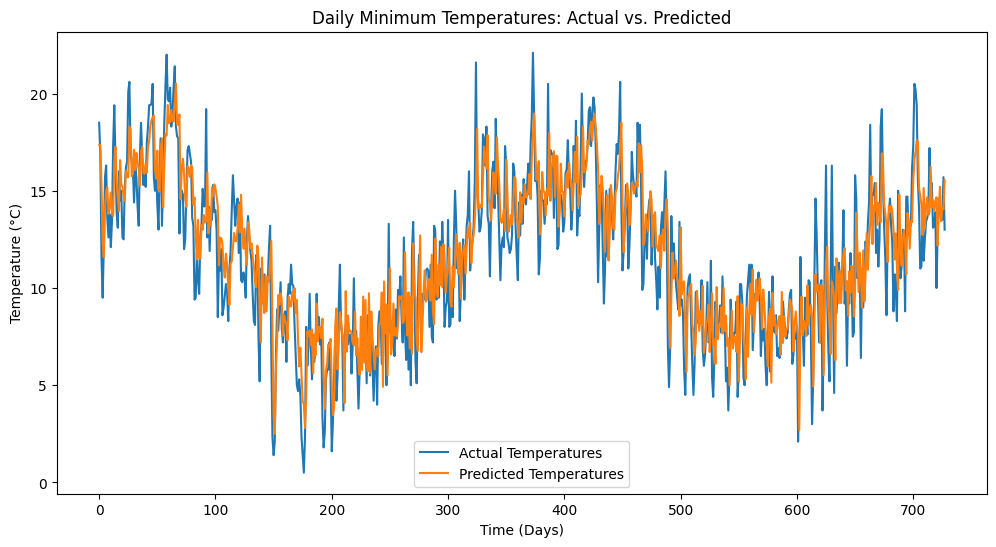

In [38]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss (Mean Squared Error): {test_loss}")

# Make predictions on the test set
predicted_scaled_temperatures = model.predict(X_test)

# Inverse transform the scaled predictions and actual values to the original scale
predicted_temperatures = scaler.inverse_transform(predicted_scaled_temperatures)
actual_temperatures = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(actual_temperatures, label='Actual Temperatures')
plt.plot(predicted_temperatures, label='Predicted Temperatures')
plt.title('Daily Minimum Temperatures: Actual vs. Predicted')
plt.xlabel('Time (Days)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

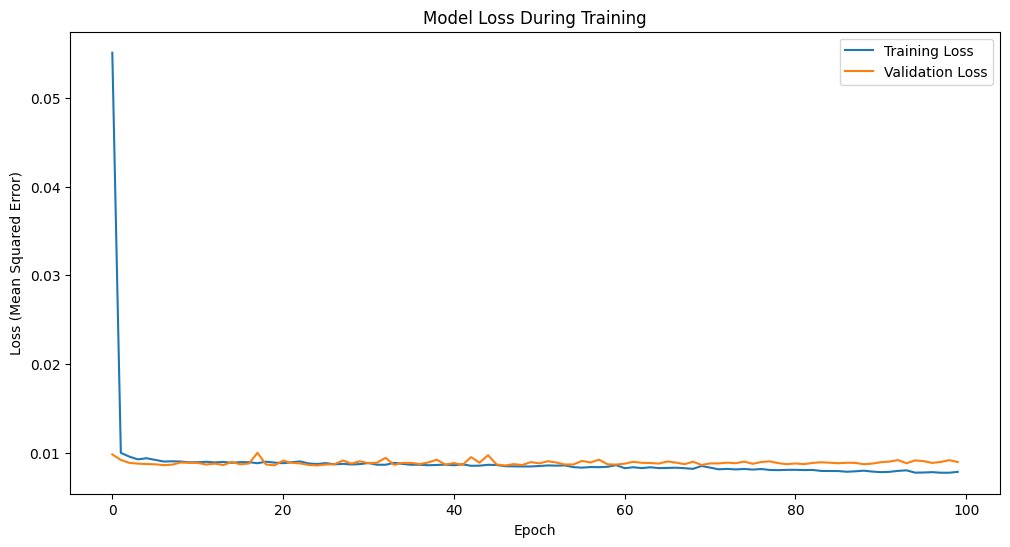

In [39]:
# Visualize the training history (loss)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

In [40]:
# Calculate RMSE on the inverse-transformed data
rmse = np.sqrt(mean_squared_error(actual_temperatures, predicted_temperatures))

print(f"Root Mean Squared Error (RMSE) on original scale: {rmse:.2f} °C")

Root Mean Squared Error (RMSE) on original scale: 2.25 °C


---
### Questions
Answer the following questions in detail.

1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.
2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?
3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?
4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?
5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.
6. Explain the role of the hidden state in an RNN. How is it updated during the training process?
7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?
8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.
9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?
10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.

---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.